# Density based clustering

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

First, a normalization is needed.

In [48]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
scaler = MinMaxScaler()
X = scaler.fit_transform(quant.values)

It is necessary to embed the dataset in a lower-dimensional space. I choose to use ISOMAP

In [49]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## DBSCAN

In [58]:
from sklearn.cluster import DBSCAN

N = 20
sil = np.zeros(N)
label_number = np.zeros(N)
max_mutual_info = np.zeros(N)
mean_mutual_info = np.zeros(N)

epsilons = np.linspace(0.19,0.32, N)
for i,eps in enumerate(epsilons):
    clustering = DBSCAN(eps=eps, min_samples=20).fit(X)
    if not np.all(clustering.labels_==-1) :
        filter_outlier = (clustering.labels_ != -1)
        label_number[i] = len(np.unique(clustering.labels_[filter_outlier]))
        if len(np.unique(clustering.labels_[filter_outlier])) > 1:
            sil[i] = silhouette_score(X[filter_outlier], clustering.labels_[filter_outlier])
    else:
        sil[i] = 0
        label_number[i] = 0

    for cat in categ.columns:
        max_mutual_info[i] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), max_mutual_info[i])
        mean_mutual_info[i] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)

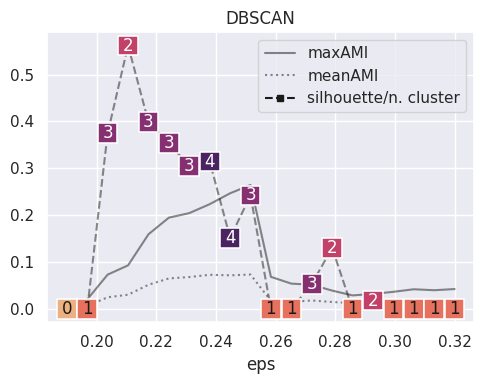

In [59]:
dummy_df = pd.DataFrame()
dummy_df["eps"] = epsilons
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number
dummy_df["maxAMI"] = max_mutual_info
dummy_df["meanAMI"] = mean_mutual_info

fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dummy_df, x="eps", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dummy_df, x="eps", y="meanAMI", color="k", alpha=0.5, ls=":")

sns.lineplot(data=dummy_df, x="eps", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="eps", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 1:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["eps"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                Line2D([0], [0], color='k', alpha=0.5, ls=":", label='meanAMI'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("DBSCAN")
plt.ylabel("")
plt.savefig("DBSCAN_sil.pdf")

/tmp/ipykernel_136441/2454298872.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/2454298872.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/2454298872.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/2454298872.py:7: Futu

,category,AMI
0,vocal_channel,0.087387
1,emotion,0.009985
2,emotional_intensity,0.002250
3,statement,0.002638
4,repetition,0.001793
5,sex,0.067725


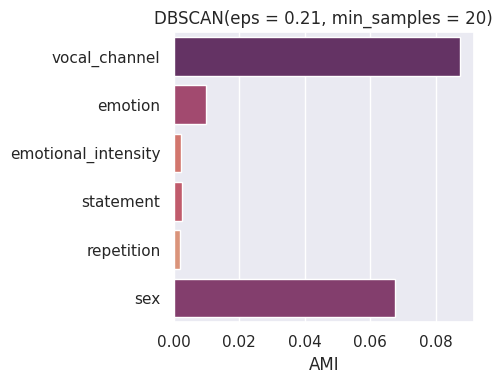

In [52]:
eps, min_samples = 0.21, 20
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

mi_df= pd.DataFrame(columns = ["category", "AMI"])

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)

display(mi_df)
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=mi_df, x ="AMI", y="category", hue="AMI", dodge=False, palette="flare", width=.8)
plt.ylabel("")
plt.title(f"DBSCAN(eps = {eps:.2}, min_samples = {min_samples})")
plt.legend([],[], frameon=False)
plt.savefig("DBSCAN_MI.pdf")


## OPTICS

In [53]:
from sklearn.cluster import OPTICS

minsamp = np.arange(5, 17,1)
N = len(minsamp)
sil = np.zeros(N)
label_number = np.zeros(N)
max_mutual_info = np.zeros(N)
mean_mutual_info = np.zeros(N)

for i,ms in enumerate(minsamp):
    clustering = OPTICS(min_samples=ms).fit(X)
    if not np.all(clustering.labels_==-1) :
        filter_outlier = (clustering.labels_ != -1)
        label_number[i] = len(np.unique(clustering.labels_[filter_outlier]))
        if len(np.unique(clustering.labels_[filter_outlier])) > 1:
            sil[i] = silhouette_score(X[filter_outlier], clustering.labels_[filter_outlier])
    else:
        sil[i] = 0
        label_number[i] = 0

    for cat in categ.columns:
        max_mutual_info[i] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), max_mutual_info[i])
        mean_mutual_info[i] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)

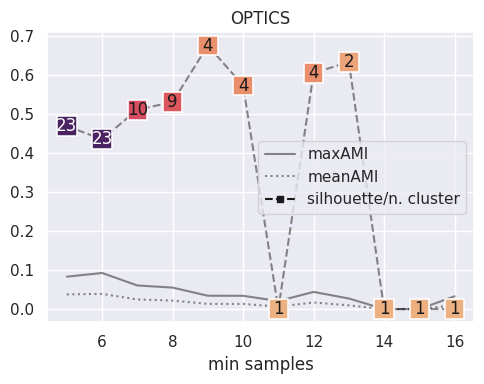

In [57]:
dummy_df = pd.DataFrame()
dummy_df["min samples"] = minsamp
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number
dummy_df["maxAMI"] = max_mutual_info
dummy_df["meanAMI"] = mean_mutual_info

fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dummy_df, x="min samples", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dummy_df, x="min samples", y="meanAMI", color="k", alpha=0.5, ls=":")

sns.lineplot(data=dummy_df, x="min samples", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="min samples", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["min samples"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    Line2D([0], [0], color='k', alpha=0.5, ls=":", label='meanAMI'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. cluster', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("OPTICS")
plt.ylabel("")
plt.savefig("OPTICS_sil.pdf")

/tmp/ipykernel_136441/1085698938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/1085698938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/1085698938.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)
/tmp/ipykernel_136441/1085698938.py:8: Futu

,category,AMI
0,vocal_channel,0.034189
1,emotion,0.010303
2,emotional_intensity,0.003101
3,statement,-0.001216
4,repetition,-0.000657
5,sex,0.034091


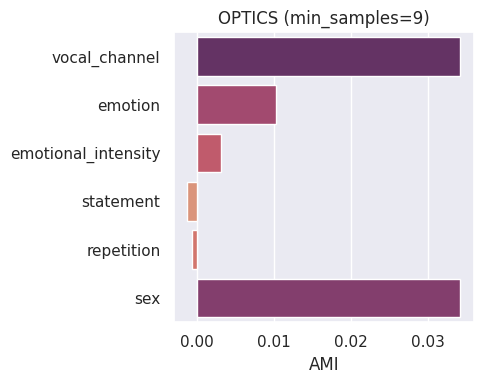

In [55]:
min_samples = 9

clustering = OPTICS(min_samples=min_samples).fit(X)

mi_df= pd.DataFrame(columns = ["category", "AMI"])

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)] }), ignore_index=True)

display(mi_df)
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(data=mi_df, x ="AMI", y="category", hue="AMI", dodge=False, palette="flare", width=.8)
plt.ylabel("")
plt.title(f"OPTICS (min_samples={min_samples})")
plt.legend([],[], frameon=False)
plt.savefig("OPTICS_MI.pdf")